### Домашнее задание к лекции 4.3 «Работа с данными»

In [1]:
import requests

import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.vq import whiten, kmeans2

%matplotlib inline

In [2]:
def call_api(uri, result_key):
    json = {}
    TOKEN = '1bf65d2b230a4734ae2a989a19e14ea9'
    try:
        json = requests.get(uri, headers = { 'X-Auth-Token': TOKEN }).json()
        return json[result_key]
    except:
        print(json)
        return None

Получаем команды (Лига Чемпионов 2016/17 => id=440):

In [3]:
teams = call_api('http://api.football-data.org/v1/competitions/440/teams', 'teams')
teams

[{'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/729/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/729/players'},
   'self': {'href': 'http://api.football-data.org/v1/teams/729'}},
  'code': None,
  'crestUrl': 'http://upload.wikimedia.org/wikipedia/commons/c/c5/FC_Basel.png',
  'name': 'FC Basel',
  'shortName': 'Basel',
  'squadMarketValue': '52,900,000 €'},
 {'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/753/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/753/players'},
   'self': {'href': 'http://api.football-data.org/v1/teams/753'}},
  'code': 'LUD',
  'crestUrl': 'http://upload.wikimedia.org/wikipedia/commons/8/87/Ludogorets_FC.png',
  'name': 'Ludogorez Rasgrad',
  'shortName': 'Ludogorez',
  'squadMarketValue': '40,100,000 €'},
 {'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/5/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/5/

Готовим данные для трансформации в Pandas

In [4]:
team_for_pd = []
for team in teams:
    
    # Считаем проигрыши только в турнире ЛЧ
    fixtures = call_api(team['_links']['fixtures']['href'], 'fixtures')
    team['losses'] = 0
    for f in fixtures:
        if f['_links']['competition']['href'] == 'http://api.football-data.org/v1/competitions/440' and\
                (f['result']['goalsHomeTeam'] or f['result']['goalsAwayTeam']) != None:
            # Команда, забившая меньше, прогрывает (ничьи не считаем вообще)
            if (team['name'] == f['homeTeamName'] and f['result']['goalsHomeTeam'] < f['result']['goalsAwayTeam']) or\
                    (team['name'] == f['awayTeamName'] and f['result']['goalsHomeTeam'] > f['result']['goalsAwayTeam']):
                team['losses'] += 1
    # Переводим стоимость в число
    if team['squadMarketValue']:
        team['squadMarketValue'] = int(str(team['squadMarketValue']).replace('€','').replace(',','').strip())
        # Если стоимости нет, то не добавляем
        team_for_pd.append({'name': team['name'], 'squadMarketValue': team['squadMarketValue'], 'losses': team['losses']})
            
team_for_pd

[{'losses': 4, 'name': 'FC Basel', 'squadMarketValue': 52900000},
 {'losses': 3, 'name': 'Ludogorez Rasgrad', 'squadMarketValue': 40100000},
 {'losses': 2, 'name': 'FC Bayern München', 'squadMarketValue': 582225000},
 {'losses': 4, 'name': 'PSV Eindhoven', 'squadMarketValue': 112700000},
 {'losses': 1,
  'name': 'Club Atlético de Madrid',
  'squadMarketValue': 493000000},
 {'losses': 2, 'name': 'FC Barcelona', 'squadMarketValue': 741500000},
 {'losses': 3, 'name': 'Dynamo Kyiv', 'squadMarketValue': 123250000},
 {'losses': 2, 'name': 'SSC Napoli', 'squadMarketValue': 295875000},
 {'losses': 2, 'name': 'SL Benfica', 'squadMarketValue': 180150000},
 {'losses': 0, 'name': 'Paris Saint-Germain', 'squadMarketValue': 412650000},
 {'losses': 1, 'name': 'Arsenal FC', 'squadMarketValue': 468500000},
 {'losses': 1, 'name': 'Borussia Dortmund', 'squadMarketValue': 339500000},
 {'losses': 2, 'name': 'Olympique Lyonnais', 'squadMarketValue': 171450000},
 {'losses': 6, 'name': 'GNK Dinamo Zagreb', 's

Трансформируем

In [5]:
teams_pd = pd.DataFrame(team_for_pd)
teams_pd

,losses,name,squadMarketValue
0,4,FC Basel,52900000
1,3,Ludogorez Rasgrad,40100000
2,2,FC Bayern München,582225000
3,4,PSV Eindhoven,112700000
4,1,Club Atlético de Madrid,493000000
5,2,FC Barcelona,741500000
6,3,Dynamo Kyiv,123250000
7,2,SSC Napoli,295875000
8,2,SL Benfica,180150000
9,0,Paris Saint-Germain,412650000


Отображаем

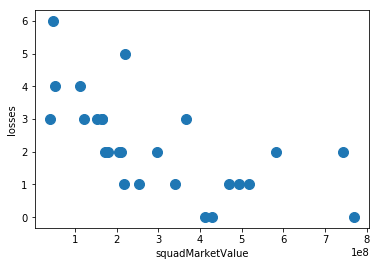

In [6]:
teams_pd.plot.scatter(x='squadMarketValue', y='losses', s=100)

Удаляем колонку с именами

In [7]:
del teams_pd['name']
teams_pd

,losses,squadMarketValue
0,4,52900000
1,3,40100000
2,2,582225000
3,4,112700000
4,1,493000000
5,2,741500000
6,3,123250000
7,2,295875000
8,2,180150000
9,0,412650000


Нормализация данных

In [8]:
whitened = whiten(teams_pd.as_matrix())
whitened

array([[ 2.72460509,  0.26677363],
       [ 2.04345382,  0.20222349],
       [ 1.36230254,  2.93614886],
       [ 2.72460509,  0.56834381],
       [ 0.68115127,  2.486189  ],
       [ 1.36230254,  3.73936945],
       [ 2.04345382,  0.62154725],
       [ 1.36230254,  1.49209162],
       [ 1.36230254,  0.90849279],
       [ 0.        ,  2.08098558],
       [ 0.68115127,  2.36263599],
       [ 0.68115127,  1.71209161],
       [ 1.36230254,  0.86461887],
       [ 4.08690763,  0.24332377],
       [ 0.        ,  2.15839531],
       [ 0.68115127,  1.10138677],
       [ 1.36230254,  1.03330654],
       [ 1.36230254,  1.06154723],
       [ 0.        ,  3.87956429],
       [ 3.40575636,  1.11071628],
       [ 0.68115127,  1.28041255],
       [ 2.04345382,  0.76981085],
       [ 0.68115127,  2.61226349],
       [ 2.04345382,  0.83511744],
       [ 2.04345382,  1.84320908],
       [ 2.04345382,  0.82830942]])

Сделаем 3 кластера

In [9]:
centroids, cluster_map = kmeans2(whitened, 3)
centroids, cluster_map

(array([[ 1.57188755,  0.98785184],
        [ 3.23546854,  0.54728937],
        [ 0.6054678 ,  2.66307151]]),
 array([1, 0, 2, 1, 2, 2, 0, 0, 0, 2, 2, 2, 0, 1, 2, 0, 0, 0, 2, 1, 0, 0, 2,
        0, 0, 0]))

Зададим цвета для каждого кластера

In [10]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]
colors

['g',
 'r',
 'b',
 'g',
 'b',
 'b',
 'r',
 'r',
 'r',
 'b',
 'b',
 'b',
 'r',
 'g',
 'b',
 'r',
 'r',
 'r',
 'b',
 'g',
 'r',
 'r',
 'b',
 'r',
 'r',
 'r']

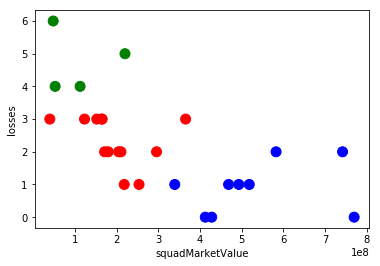

In [11]:
teams_pd.plot.scatter(x='squadMarketValue', y='losses', c=colors, s=100)

Теперь попробуем сделать больше кластеров.

In [12]:
centroids, cluster_map = kmeans2(whitened, 5)
centroids, cluster_map

(array([[ 2.04345382,  0.65140169],
        [ 1.21093559,  1.25523967],
        [ 0.59600736,  2.781944  ],
        [ 2.95165551,  0.64861124],
        [ 4.08690763,  0.24332377]]),
 array([3, 0, 2, 3, 2, 2, 0, 1, 1, 2, 2, 1, 1, 4, 2, 1, 1, 1, 2, 3, 1, 0, 2,
        0, 1, 0]))

In [13]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]
colors

['y',
 'r',
 'b',
 'y',
 'b',
 'b',
 'r',
 'g',
 'g',
 'b',
 'b',
 'g',
 'g',
 'm',
 'b',
 'g',
 'g',
 'g',
 'b',
 'y',
 'g',
 'r',
 'b',
 'r',
 'g',
 'r']

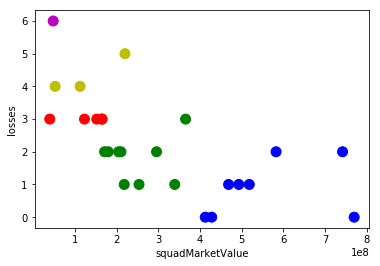

In [14]:
teams_pd.plot.scatter(x='squadMarketValue', y='losses', c=colors, s=100)